In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
print('Running openCV: ', cv2.__version__)

#import linear_features as lf

plt.rcParams['figure.figsize'] = (16,3)

Running openCV:  4.4.0


In [2]:
def get_image(path):
    stream = open(f'{path}', "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    img = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    return img

def show_img(image, figsize=(16, 9), ticks=False, title=False, grid=False):
    """
    show image with some parameters (just to reduce the lines of code in usage)
    :param image: image to show
    :param figsize: size of figure
    :param ticks: are x,y-ticks needed ot not
    :param title: the title for image
    :param grid: is grid needed or not
    :return:
    """
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not ticks:
        plt.xticks([]), plt.yticks([])
    if grid:
        plt.grid(which='both', color='r')
    if title:
        plt.title(title)
    plt.show()

**Приобразуем датафрейм, чтобы с ним было удобней работать**

In [98]:
downloaded_days = ['02', '03', '04', '05', '06', '07', '09', '13',
                   '15', '16', '17', '18', '19', '20', '21', '22',
                   '23', '24', '25', '26', '27', '30', '31']

In [99]:
nek = pd.read_csv('nek_streamlit.csv')
nek['path'] = nek['path'].apply(lambda x: x.replace('scan_track_video/2020_01', 'part_1'))
nek['day'] = nek['path'].apply(lambda x: x[7:9])
nek = nek[nek['day'].isin(downloaded_days)]

nek['front_frames'] = nek['front_frames'].apply(lambda x: x[1:-2].replace('\'', ' ').replace(',', ' ').split())

In [160]:
df_frames = pd.DataFrame()

count = 0
for path in nek['path'].unique():
    if count > 50:
        break
    
    t = np.hstack((nek[nek['path'] == path]['front_frames']))
    features = {
    'path': path.replace('scan_track_video/2020_01', 'part_1') + '/FrontJPG',
    'frames': t
    }
    df_frames = df_frames.append(features, ignore_index=True)
    
    count += 1

In [161]:
df_frames.head()

,frames,path
0,"[front0.jpg, front1.jpg, front2.jpg, front3.jp...",part_1/21/224923_М636МВ10/FrontJPG
1,"[front11.jpg, front12.jpg, front13.jpg, front1...",part_1/21/064710_м571ом10/FrontJPG
2,"[front1.jpg, front2.jpg, front3.jpg, front4.jp...",part_1/21/001320_М636МВ10/FrontJPG
3,"[front5.jpg, front6.jpg, front7.jpg, front8.jp...",part_1/21/153115_М434РУ10/FrontJPG
4,"[front5.jpg, front6.jpg, front7.jpg, front8.jp...",part_1/21/013013_н102ра10/FrontJPG


In [162]:
t = df_frames[df_frames['path'] == 'part_1/21/224923_М636МВ10/FrontJPG']['frames']

In [163]:
data = pd.DataFrame(columns=['path', 'y'])

for path in df_frames['path']:
    frames2class = {}
    frames = os.listdir(path)
    frames_nek = df_frames[df_frames['path'] == path]['frames'].iloc[0]
    
    for frame in frames:
        frame_num = int(''.join(char for char in frame if char.isdigit()))
        if frame in frames_nek and frame_num >= 5:
            data = data.append({'path': f'{path}/{frame}', 'y': 1}, ignore_index=True)
        else:
            data = data.append({'path': f'{path}/{frame}', 'y': 0}, ignore_index=True)

In [164]:
data

,path,y
0,part_1/21/224923_М636МВ10/FrontJPG/front0.jpg,0
1,part_1/21/224923_М636МВ10/FrontJPG/front1.jpg,0
2,part_1/21/224923_М636МВ10/FrontJPG/front10.jpg,1
3,part_1/21/224923_М636МВ10/FrontJPG/front11.jpg,1
4,part_1/21/224923_М636МВ10/FrontJPG/front12.jpg,0
...,...,...
3659,part_1/06/134443_м384ну10/FrontJPG/front90.jpg,0
3660,part_1/06/134443_м384ну10/FrontJPG/front91.jpg,0
3661,part_1/06/134443_м384ну10/FrontJPG/front92.jpg,0
3662,part_1/06/134443_м384ну10/FrontJPG/front93.jpg,0


# Приступим к обучению

In [126]:
import torch
import torchvision.transforms as T
import torchvision
import datetime
from PIL import Image


from sklearn.model_selection import train_test_split

In [165]:
train, test = train_test_split(data, test_size=0.2)

In [166]:
input_size = 224
batch_size = 32

transform = T.Compose(
           [T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
            ])

class myDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row['path'])
        area = (750, 180, 1400, 970)
        image = image.crop(area)
        label = row['y']
        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    
dataset_train = myDataset(train, transform)
dataset_test = myDataset(test, transform)

dataloaders_dict = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
                    'val': torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [167]:
import torchvision.models as models
import time
import copy

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_err_history = []
    train_err_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_err_history.append(epoch_loss)
            if phase == 'train':
                train_err_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_err_history, train_err_history

In [168]:
feature_extract = True
num_classes = 2
model_ft = models.resnet34(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

In [169]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [170]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 50
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.4056 Acc: 0.8308
val Loss: 0.3585 Acc: 0.8554

Epoch 1/49
----------
train Loss: 0.3108 Acc: 0.8792
val Loss: 0.3280 Acc: 0.8663

Epoch 2/49
----------
train Loss: 0.2825 Acc: 0.8946
val Loss: 0.3106 Acc: 0.8745

Epoch 3/49
----------
train Loss: 0.2652 Acc: 0.8953
val Loss: 0.3189 Acc: 0.8813

Epoch 4/49
----------
train Loss: 0.2575 Acc: 0.8973
val Loss: 0.3033 Acc: 0.8731

Epoch 5/49
----------
train Loss: 0.2630 Acc: 0.8987
val Loss: 0.3097 Acc: 0.8677

Epoch 6/49
----------
train Loss: 0.2433 Acc: 0.9110
val Loss: 0.2935 Acc: 0.8772

Epoch 7/49
----------
train Loss: 0.2473 Acc: 0.9092
val Loss: 0.2914 Acc: 0.8854

Epoch 8/49
----------
train Loss: 0.2414 Acc: 0.9075
val Loss: 0.2879 Acc: 0.8813

Epoch 9/49
----------
train Loss: 0.2331 Acc: 0.9113
val Loss: 0.3024 Acc: 0.8731

Epoch 10/49
----------
train Loss: 0.2357 Acc: 0.9092
val Loss: 0.2921 Acc: 0.8868

Epoch 11/49
----------
train Loss: 0.2363 Acc: 0.9096
val Loss: 0.2867 Acc: 0.8827

Ep

[]

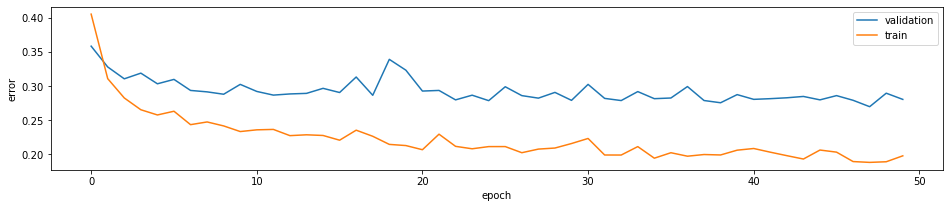

In [172]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [171]:
torch.save(model_ft, 'models/resnet34_splitter.pth')

In [180]:
trucks = ['part_1/09/212845_О376ТН47',
         'part_1/21/224923_М636МВ10',
         'part_1/05/062112_м475рр10',
         'part_1/15/161657_М493ЕЕ10',
         'part_1/06/131352_М136НС10',
         'part_1/30/173809_В712УМ47']

In [185]:
transform = T.Compose(
           [T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
            ])

df_pack = pd.DataFrame(columns=['path', 'is_pack'])
with torch.no_grad():
    for truck in trucks:
        frames = os.listdir(f'{truck}/FrontJPG/')
        for frame in frames:
            image = Image.open(f'{truck}/FrontJPG/{frame}')
            area = (750, 180, 1400, 970)
            image = image.crop(area)
            image = transform(image)
            image = torch.unsqueeze(image, 0)
            image = image.cuda()
    
            t = np.argmax(model_ft(image).cpu().numpy())
            df_pack = df_pack.append({'path': f'{truck}/FrontJPG/{frame}', 'is_pack': t}, ignore_index=True)

In [186]:
df_pack.head()

,path,is_pack
0,part_1/09/212845_О376ТН47/FrontJPG/front0.jpg,0
1,part_1/09/212845_О376ТН47/FrontJPG/front1.jpg,0
2,part_1/09/212845_О376ТН47/FrontJPG/front10.jpg,1
3,part_1/09/212845_О376ТН47/FrontJPG/front11.jpg,1
4,part_1/09/212845_О376ТН47/FrontJPG/front12.jpg,1


In [188]:
df_pack.to_csv('pack.csv', index=False)